### Loading the train and test logits/likelyhoods

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn

cal_path = 'calibration_logits.pth'
test_path = 'test_logits.pth'

cal_data = torch.load(cal_path, weights_only=False)
test_data = torch.load(test_path, weights_only=False)

cal_logits = cal_data["logits"] 
cal_images = cal_data["images"]  
cal_gt_masks = cal_data["masks"]    
cal_probs = F.softmax(cal_logits, dim=1)

test_logits = test_data["logits"] 
test_images = test_data["images"]  
test_gt_masks = test_data["masks"]    
test_probs = F.softmax(test_logits, dim=1)

### Obtaining Lower Bound

In [2]:
def obtain_lower_bound(probs, alpha=0.1, eps=1e-6):
    
    assert probs.dim() == 4, "Input probabilities must be a 4D tensor."
    
    entropy = -torch.sum(probs * torch.log(probs + eps), dim=1)  # (N, H, W)
    lower_bound = (probs - alpha * entropy.unsqueeze(1)).clamp(0, 1)       # (N, C, H, W)

    return lower_bound

cal_lower_bound = obtain_lower_bound(cal_probs)
test_lower_bound = obtain_lower_bound(test_probs)

### Visualize distribution of likelyhood by class

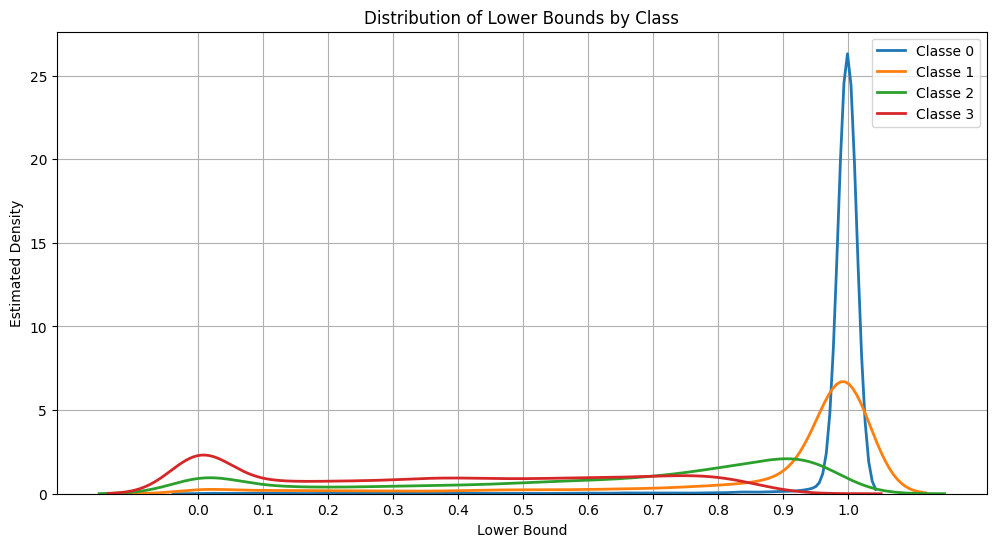

In [3]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_lower_bound_distribution(lower_bound, labels, sample_size=10000):
    
    N, C, H, W = lower_bound.shape

    plt.figure(figsize=(12, 6))

    for c in range(C):
        mask = (labels == c).unsqueeze(1)  # shape: (N, 1, H, W)
        lower_c = lower_bound[:, c, :, :][mask.squeeze(1)]

        if lower_c.numel() > sample_size:
            indices = torch.randperm(lower_c.numel())[:sample_size]
            lower_c = lower_c[indices]

        sns.kdeplot(lower_c.cpu().numpy(), label=f'Classe {c}', linewidth=2)

    plt.title("Distribution of Lower Bounds by Class")
    plt.xlabel("Lower Bound")
    plt.ylabel("Estimated Density")
    plt.legend()
    plt.xticks(np.arange(0, 1.1, 0.1)) 
    plt.grid(True)
    plt.show()

plot_lower_bound_distribution(cal_lower_bound, cal_gt_masks)

### Imprecise Functions 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import average_precision_score


def imprecise_probs_and_likelihoods(lower_bound, thresholds):
    num_classes = lower_bound.shape[1]
    confident_mask = torch.zeros_like(lower_bound, dtype=torch.bool)

    for c in range(num_classes):
        confident_mask[:, c, :, :] = lower_bound[:, c, :, :] > thresholds[c]

    confident_values = confident_mask.float() * lower_bound

    pred_conservative = confident_values.argmax(dim=1)
    is_uncertain = confident_mask.max(dim=1).values == 0
    pred_conservative[is_uncertain] = 255  # 255 for uncertain pixels

    return pred_conservative, confident_values, confident_mask


def fill_uncertain_probs_with_baseline(confident_values, confident_mask, baseline_probs):

    # Create a mask of uncertain pixels (1 if all classes are uncertain)
    uncertain_mask = confident_mask.max(dim=1).values == 0  # (N, H, W)

    # Start with confident_values, but baseline_probs will overwrite uncertain pixels
    final_probs = confident_values.clone()

    # For uncertain pixels, fill with baseline_probs
    for c in range(final_probs.shape[1]):
        final_probs[:, c, :, :][uncertain_mask] = baseline_probs[:, c, :, :][uncertain_mask]

    # Final predictions (argmax)
    pred_filled = final_probs.argmax(dim=1)
    return final_probs, pred_filled


### Metric and Visualization Functions

In [15]:
def flatten_probs_labels(probs, labels):
    N, C, H, W = probs.shape
    probs_flat = probs.permute(0, 2, 3, 1).reshape(-1, C)  # (N*H*W, C)
    labels_flat = labels.view(-1)  # (N*H*W,)
    return probs_flat, labels_flat

def compute_average_precision(probs, labels, num_classes=4):
    probs_flat, labels_flat = flatten_probs_labels(probs, labels)
    AP_per_class = []

    for c in range(num_classes):
        # True binary labels for class c (1 if pixel == c, 0 otherwise)
        true_binary = (labels_flat == c).cpu().numpy()
        # Probabilities for class c
        prob_c = probs_flat[:, c].cpu().numpy()

        if np.sum(true_binary) == 0:
            AP_per_class.append(np.nan)  # No positive samples, skip
        else:
            AP = average_precision_score(true_binary, prob_c)
            AP_per_class.append(AP)

    # Mean AP (mAP), ignoring NaNs
    mAP = np.nanmean(AP_per_class)
    return AP_per_class, mAP

def compute_ece(probs, labels, num_bins=10):
    # Convert to numpy
    probs_flat, labels_flat = flatten_probs_labels(probs, labels)
    confidences, predictions = torch.max(probs_flat, dim=1)
    confidences = confidences.cpu().numpy()
    predictions = predictions.cpu().numpy()
    labels_flat = labels_flat.cpu().numpy()

    bin_boundaries = np.linspace(0.0, 1.0, num_bins + 1)
    ece = 0.0

    for i in range(num_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]

        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)

        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(predictions[in_bin] == labels_flat[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    return ece

def calculate_coverage(probs, thresholds):
    # Create confident mask: True if prob > threshold for each class
    confident_mask = torch.zeros_like(probs, dtype=torch.bool)
    for c in range(probs.shape[1]):
        confident_mask[:, c, :, :] = probs[:, c, :, :] > thresholds[c]
    # A pixel is certain if at least one class is confident
    certain_pixels = confident_mask.max(dim=1).values  # (N, H, W)
    coverage = float(certain_pixels.sum().item()) / certain_pixels.numel()
    return coverage
 
def plot_segmentation_comparison_with_uncertainty(images, masks, preds_baseline, preds_imprecise, image_idx=0, ignore_class=255):
    img = images[image_idx][:3].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    gt = masks[image_idx].cpu().numpy()
    base = preds_baseline[image_idx].cpu().numpy()
    cons = preds_imprecise[image_idx].cpu().numpy()


    cons_vis = cons.copy()
    cons_vis[cons_vis == ignore_class] = -1  
    
    # Plot
    fig, axs = plt.subplots(1, 4, figsize=(24, 5))
    axs[0].imshow(img)
    axs[0].set_title("Original Image")
    axs[1].imshow(gt, cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(base, cmap='gray')
    axs[2].set_title("Baseline Prediction")
    axs[3].imshow(cons_vis, cmap='gray')
    axs[3].set_title("Prediction with Imprecise Probabilities")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def print_metrics(probs, labels, thresholds, name=None):
    APs, mAP = compute_average_precision(probs, labels)
    ece = compute_ece(probs, labels)
    coverage = calculate_coverage(probs, thresholds)

    print(f"\n=== {name} ===")
    print("Average Precision per class:", [f"{ap:.4f}" if ap is not None and not np.isnan(ap) else "nan" for ap in APs])
    print("Mean Average Precision (mAP):", f"{mAP:.4f}")
    print("Expected Calibration Error (ECE):", f"{ece:.4f}")
    print("Coverage (proportion of certain pixels):", f"{coverage:.4f}")


def compute_metrics_certain_pixels(probs, labels, confident_mask, num_classes=4):
    # A pixel is certain if at least one class is confident
    certain_pixels = confident_mask.max(dim=1).values.bool()  # (N, H, W)
    
    # Flatten everything
    N, C, H, W = probs.shape
    probs_flat = probs.permute(0, 2, 3, 1).reshape(-1, C)
    labels_flat = labels.view(-1)
    certain_flat = certain_pixels.view(-1)
    
    # Filter only certain pixels
    probs_certain = probs_flat[certain_flat]
    labels_certain = labels_flat[certain_flat]
    
    # Coverage: proportion of certain pixels
    coverage = float(certain_flat.sum().item()) / certain_flat.numel()
    
    # If no certain pixels, return NaN
    if probs_certain.shape[0] == 0:
        return [float('nan')] * num_classes, float('nan'), float('nan'), 0.0
    
    # Average Precision
    AP_per_class = []
    for c in range(num_classes):
        true_binary = (labels_certain == c).cpu().numpy()
        prob_c = probs_certain[:, c].cpu().numpy()
        if np.sum(true_binary) == 0:
            AP_per_class.append(np.nan)
        else:
            AP = average_precision_score(true_binary, prob_c)
            AP_per_class.append(AP)
    mAP = np.nanmean(AP_per_class)
    
    # ECE
    confidences = probs_certain.max(dim=1).values.cpu().numpy()
    predictions = probs_certain.argmax(dim=1).cpu().numpy()
    labels_certain_np = labels_certain.cpu().numpy()
    num_bins = 10
    bin_boundaries = np.linspace(0.0, 1.0, num_bins + 1)
    ece = 0.0
    for i in range(num_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(predictions[in_bin] == labels_certain_np[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    print(f"\n=== Imprecise Probability Approach Metrics for Certain Pixels ===")
    print("Average Precision per class:", [f"{ap:.4f}" if ap is not None and not np.isnan(ap) else "nan" for ap in AP_per_class])
    print("Mean Average Precision (mAP):", f"{mAP:.4f}")
    print("Expected Calibration Error (ECE):", f"{ece:.4f}")
    print("Coverage (proportion of certain pixels):", f"{coverage:.4f}")

### Threshold with Quartile

In [16]:
def thresholds_from_lower_percentile(lower_bound, labels, quartile, max_samples=100_000):
   
    N, C, H, W = lower_bound.shape

    thresholds = []
    for c in range(C):
        mask = (labels == c).unsqueeze(1)  # shape: (N, 1, H, W)
        lower_c = lower_bound[:, c, :, :][mask.squeeze(1)]

        if lower_c.numel() == 0:
            thresholds.append(0.5)  # fallback
        else:
            if lower_c.numel() > max_samples:
                indices = torch.randperm(lower_c.numel())[:max_samples]
                lower_c = lower_c[indices]
            
                if f'class{c}' in quartile:
                    q = quartile[f'class{c}']
                    
            threshold = torch.quantile(lower_c, q).item()
            thresholds.append(threshold)

    return thresholds

In [ ]:
import concurrent.futures

def optimize_quartiles(cal_lower_bound, cal_gt_masks, cal_probs, num_folds=3, quartile_range=[0.25, 0.5, 0.75]):
    N = cal_lower_bound.shape[0]
    indices = np.arange(N)
    np.random.shuffle(indices)
    fold_size = N // num_folds

    best_quartiles = {}
    best_score = -float('inf')

    from itertools import product
    quartile_combinations = list(product(quartile_range, repeat=4))

    def evaluate_quartile_combo(combo):
        q0, q1, q2, q3 = combo
        quartile = {'class0': q0, 'class1': q1, 'class2': q2, 'class3': q3}
        scores = []
        for fold in range(num_folds):
            val_indices = indices[fold * fold_size:(fold + 1) * fold_size]
            train_indices = np.setdiff1d(indices, val_indices)

            train_lower_bound = cal_lower_bound[train_indices]
            train_gt_masks = cal_gt_masks[train_indices]
            thresholds = thresholds_from_lower_percentile(train_lower_bound, train_gt_masks, quartile)

            val_lower_bound = cal_lower_bound[val_indices]
            val_gt_masks = cal_gt_masks[val_indices]
            val_probs = cal_probs[val_indices]

            _, confident_values, confident_mask = imprecise_probs_and_likelihoods(val_lower_bound, thresholds)
            final_probs, _ = fill_uncertain_probs_with_baseline(confident_values, confident_mask, val_probs)

            _, mAP = compute_average_precision(final_probs, val_gt_masks)
            ece = compute_ece(final_probs, val_gt_masks)

            score = mAP - ece
            scores.append(score)
        avg_score = np.mean(scores)
        return avg_score, quartile

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(evaluate_quartile_combo, quartile_combinations))

    for avg_score, quartile in results:
        if avg_score > best_score:
            best_score = avg_score
            best_quartiles = quartile.copy()

    return best_quartiles

optimized_quartiles = optimize_quartiles(cal_lower_bound, cal_gt_masks, cal_probs, num_folds=3, quartile_range=[0.25, 0.5, 0.75])
thresholds = thresholds_from_lower_percentile(cal_lower_bound, cal_gt_masks, optimized_quartiles)
print("Thresholds for each class:", [f"{t:.4f}" for t in thresholds])

In [ ]:
print_metrics(test_probs, test_gt_masks, thresholds, name="Baseline Metrics")

_, confident_values, confident_mask = imprecise_probs_and_likelihoods(test_lower_bound, thresholds)
final_probs, pred_filled = fill_uncertain_probs_with_baseline(confident_values, confident_mask, test_probs)
print_metrics(final_probs, test_gt_masks, thresholds, name="Imprecise Probability Approach Metrics")

compute_metrics_certain_pixels(confident_values, test_gt_masks, confident_mask)


=== Baseline Metrics ===
Average Precision per class: ['0.9997', '0.9828', '0.6978', '0.3823']
Mean Average Precision (mAP): 0.7657
Expected Calibration Error (ECE): 0.0023

=== Imprecise Probability Approach Metrics ===
Average Precision per class: ['0.9997', '0.9816', '0.6968', '0.3819']
Mean Average Precision (mAP): 0.7650
Expected Calibration Error (ECE): 0.0021

=== Imprecise Probability Approach Metrics for Certain Pixels ===
Average Precision per class: ['0.9999', '0.9895', '0.8612', '0.6651']
Mean Average Precision (mAP): 0.8789
Expected Calibration Error (ECE): 0.0005
Coverage (proportion of certain pixels): 0.7385


### Interpolation smooth between Baseline and Imprecise Probability

In [7]:
def smooth_interpolation(confident_values, confident_mask, baseline_probs, alpha=0.5):
    # Calculate weight for each pixel based on the maximum confidence
    max_confidence = confident_mask.float().max(dim=1, keepdim=True)[0]

    # Interpolate between confident_values and baseline_probs
    interpolated_probs = alpha * max_confidence * confident_values + (1 - alpha * max_confidence) * baseline_probs

    # Normalize to ensure probabilities sum to 1
    interpolated_probs = interpolated_probs / interpolated_probs.sum(dim=1, keepdim=True).clamp(min=1e-6)

    return interpolated_probs

In [8]:
from itertools import product

def optimize_quartiles_with_smooth_interpolation(cal_lower_bound, cal_gt_masks, cal_probs, num_folds=3, quartile_range=[0.25, 0.5, 0.75], alpha=0.5):
    N = cal_lower_bound.shape[0]
    indices = np.arange(N)
    np.random.shuffle(indices)
    fold_size = N // num_folds

    best_quartiles = {}
    best_score = -float('inf')

    quartile_combinations = list(product(quartile_range, repeat=4))

    def evaluate_quartile_combo(combo):
        q0, q1, q2, q3 = combo
        quartile = {'class0': q0, 'class1': q1, 'class2': q2, 'class3': q3}
        scores = []
        for fold in range(num_folds):
            val_indices = indices[fold * fold_size:(fold + 1) * fold_size]
            train_indices = np.setdiff1d(indices, val_indices)

            train_lower_bound = cal_lower_bound[train_indices]
            train_gt_masks = cal_gt_masks[train_indices]
            thresholds = thresholds_from_lower_percentile(train_lower_bound, train_gt_masks, quartile)

            val_lower_bound = cal_lower_bound[val_indices]
            val_gt_masks = cal_gt_masks[val_indices]
            val_probs = cal_probs[val_indices]

            _, confident_values, confident_mask = imprecise_probs_and_likelihoods(val_lower_bound, thresholds)
            interpolated_probs = smooth_interpolation(confident_values, confident_mask, val_probs, alpha=alpha)

            _, mAP = compute_average_precision(interpolated_probs, val_gt_masks)
            ece = compute_ece(interpolated_probs, val_gt_masks)

            score = mAP - ece
            scores.append(score)
        avg_score = np.mean(scores)
        return avg_score, quartile

    import concurrent.futures
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(evaluate_quartile_combo, quartile_combinations))

    for avg_score, quartile in results:
        if avg_score > best_score:
            best_score = avg_score
            best_quartiles = quartile.copy()

    return best_quartiles

# Example usage:
optimized_quartiles = optimize_quartiles_with_smooth_interpolation(cal_lower_bound, cal_gt_masks, cal_probs, num_folds=3, quartile_range=[0.25, 0.5, 0.75], alpha=0.5)
thresholds = thresholds_from_lower_percentile(cal_lower_bound, cal_gt_masks, optimized_quartiles)
print("Thresholds for each class:", [f"{t:.4f}" for t in thresholds])

Thresholds for each class: ['0.9999', '0.9991', '0.8823', '0.6278']


In [10]:
print_metrics(test_probs, test_gt_masks, name="Baseline Metrics")

_, confident_values, confident_mask = imprecise_probs_and_likelihoods(test_lower_bound, thresholds)
interpolated_probs = smooth_interpolation(confident_values, confident_mask, test_probs, alpha=0.7)
print_metrics(interpolated_probs, test_gt_masks, name="Imprecise Probability Approach Metrics (Smooth Interpolation)")


=== Baseline Metrics ===
Average Precision per class: ['0.9997', '0.9828', '0.6978', '0.3823']
Mean Average Precision (mAP): 0.7657
Expected Calibration Error (ECE): 0.0023

=== Imprecise Probability Approach Metrics (Smooth Interpolation) ===
Average Precision per class: ['0.9997', '0.9827', '0.6978', '0.3826']
Mean Average Precision (mAP): 0.7657
Expected Calibration Error (ECE): 0.0025
